In [31]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [32]:
ORIGINAL_FPS = 30
MANUAL_FPSS = ['3', '5', '10', '15', '30']
USE_MANUAL_FPSS = True
THRESHOLD = 0.75

INTERVAL = 15
EXPENSIVE_FPS = 30
CLASS_INDEXES = ['2']

In [33]:
result_dict_paths = [
    '../assets/result/accuracy/Video1_Result.json',
    '../assets/result/accuracy/Video2_Result.json',
    '../assets/result/accuracy/Video3_Result.json',
    '../assets/result/accuracy/Video4_Result.json',
]

In [34]:
def load_json(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    
    return data

In [35]:
FPS_ENERGY_DICT = load_json('../assets/result/energy/Dict-Per-Real-Second-960x480.json')

In [36]:
def extract_fpss(metric_list):
	  return list(metric_list[list(metric_list.keys())[0]][0]['metric'].keys())

In [37]:
def extract_frame_count(metric_list):
    return [clip_metric['frame_count'] for clip_metric in metric_list]

In [38]:
def extract_metric_list(metric_list, fpss, feature='F1', use_MANUAL_FPSS=False):
    if use_MANUAL_FPSS:
        fpss = MANUAL_FPSS
    else:
        fpss = fpss

    result_column = {}
    
    for fps in fpss: 
        result_column[fps] = [clip_metric['metric'][fps][feature] for clip_metric in metric_list]
    
    return result_column

In [39]:
def extract_accuracy_list_based_on_fps_list(metric_list, fps_list, feature='F1'):
    result_list = []
    
    for i in range(len(fps_list)):
        result_list.append(metric_list[i]['metric'][fps_list[i]][feature])
    
    return result_list

In [40]:
def find_max_index(string_list):
		# Convert each element to integer
		int_list = [int(element) for element in string_list]
		
		# Find index of maximum integer value
		max_index, max_value = max(enumerate(int_list), key=lambda x: x[1])
		
		return max_value

def extract_cheapest_fps(accuracy_dict, fpss, threshold=0.75, use_MANUAL_FPSS=False):
    if use_MANUAL_FPSS:
        fpss = MANUAL_FPSS
    else:
        fpss = fpss
          
    max_fps = find_max_index(fpss)
    
    cheapest_fpss = []
    for i in range(len(accuracy_dict[fpss[0]])):
        curr_fps = max_fps
        for fps in fpss:
          if accuracy_dict[fps][i] >= threshold and int(fps) < int(curr_fps):
            curr_fps = fps
        
        cheapest_fpss.append(int(curr_fps))
    
    return cheapest_fpss

In [41]:
def calculate_energy(fps_list, energy_dict, interval):
    total_energy = 0
    
    for fps in fps_list:
        if fps in energy_dict.keys():
            total_energy += interval * energy_dict[fps]
        else: # !!!NEED MODIFICATION!!!
            total_energy += interval * energy_dict[list(energy_dict.keys())[-1]]
    
    return total_energy

In [42]:
# result_dict = load_json(result_dict_paths[2])

# fpss = extract_fpss(result_dict)
# accuracy = extract_metric_list(result_dict['2'], fpss, 'F1', USE_MANUAL_FPSS)
# total_frame_count = np.sum(np.array(extract_frame_count(result_dict['2'])))

# cheapest_fps_list = extract_cheapest_fps(accuracy, fpss, THRESHOLD, USE_MANUAL_FPSS)
# cheapest_fps_list = [str(fps) for fps in cheapest_fps_list]
# expensive_fps_list = [str(EXPENSIVE_FPS) for i in range(len(cheapest_fps_list))]

# cheapest_energy = calculate_energy(cheapest_fps_list, FPS_ENERGY_DICT, INTERVAL) / total_frame_count
# expensive_energy = calculate_energy(expensive_fps_list, FPS_ENERGY_DICT, INTERVAL) / total_frame_count

# cheapest_average_accuracy = np.average(np.array(extract_accuracy_list_based_on_fps_list(result_dict['2'], cheapest_fps_list)))
# expensive_average_accuracy = np.average(np.array(extract_accuracy_list_based_on_fps_list(result_dict['2'], expensive_fps_list)))

In [43]:
def result_for_one_video(video_path, class_idx):
    result_dict = load_json(video_path)

    fpss = extract_fpss(result_dict)
    accuracy = extract_metric_list(result_dict[class_idx], fpss, 'F1', USE_MANUAL_FPSS)
    total_frame_count = np.sum(np.array(extract_frame_count(result_dict[class_idx])))

    cheapest_fps_list = extract_cheapest_fps(accuracy, fpss, THRESHOLD, USE_MANUAL_FPSS)
    cheapest_fps_list = [str(fps) for fps in cheapest_fps_list]
    expensive_fps_list = [str(EXPENSIVE_FPS) for i in range(len(cheapest_fps_list))]

    cheapest_energy = calculate_energy(cheapest_fps_list, FPS_ENERGY_DICT, INTERVAL) / total_frame_count * ORIGINAL_FPS
    expensive_energy = calculate_energy(expensive_fps_list, FPS_ENERGY_DICT, INTERVAL) / total_frame_count * ORIGINAL_FPS

    cheapest_average_accuracy = np.average(np.array(extract_accuracy_list_based_on_fps_list(result_dict[class_idx], cheapest_fps_list)))
    expensive_average_accuracy = np.average(np.array(extract_accuracy_list_based_on_fps_list(result_dict[class_idx], expensive_fps_list)))

    return (cheapest_energy, cheapest_average_accuracy), (expensive_energy, expensive_average_accuracy)

In [44]:
def plot_one_class_idx(class_idx, x_label, y_label, title, line_y = 0.75, label_size=28, font_size=32, legend_size=24, line_width=4, point_size=120):
    MARKERS = ['o', 'x', '+', '^']

    plt.figure(figsize=(8, 8))

    for i in range(len(result_dict_paths)):
        result_dict_path = result_dict_paths[i]
        (x1, y1), (x2, y2) = result_for_one_video(result_dict_path, class_idx)
        plt.scatter(x1, y1, color='red', marker=MARKERS[i], s=point_size)
        plt.scatter(x2, y2, color='blue', marker=MARKERS[i], s=point_size)
    
    plt.axhline(y=line_y, color='grey', linestyle='--', linewidth=line_width, label="Required Accuracy")

    # plt.title(title, fontsize=font_size)
    plt.xlabel(x_label, fontsize=font_size)
    plt.ylabel(y_label, fontsize=font_size)
    plt.xticks(fontsize=label_size)
    plt.yticks(fontsize=label_size)
    plt.xlim(3, 12)  # Set the x-axis to run from 0 to 6
    plt.ylim(0.73, 0.87) # Set the y-axis to run from 0 to 30
    plt.legend(fontsize=legend_size)
    plt.grid(True)

    plt.show()

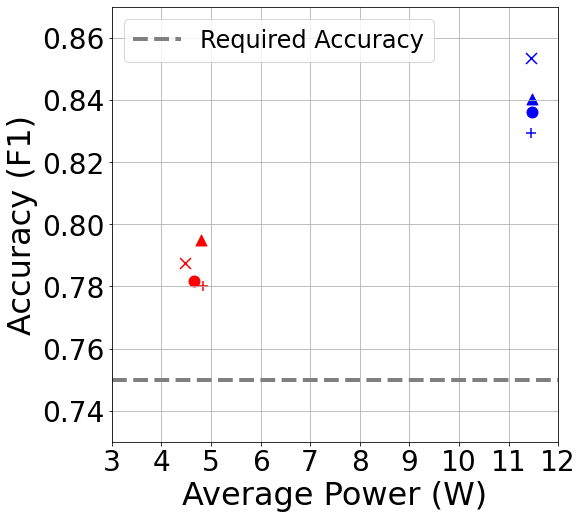

In [45]:
for class_idx in CLASS_INDEXES:
    plot_one_class_idx('2', 'Average Power (W)', 'Accuracy (F1)', 'Accuracy vs Energy Consumption', THRESHOLD)